In [1]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd
import h5py
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
df_losses_coco_final = pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_epoch_2.csv").append(
    pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_epoch_1.csv")).append(
    pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_2_epoch_2.csv")).append(
    pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_3_epoch_2.csv")
).append(
    pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_4_epoch_3.csv")
)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_losses_coco_final = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_fixedListener_pure_decoding_Ls075_49vocab_similarFixed_epoch_2.csv")#.append(pd.read_csv("../../../data/final/reference_games/coco/losses_ref_game_coco_pretrain_listener_4000vocab_random_cont_epoch_2.csv"))
# df_losses_coco_final2 = pd.read_csv("../../../data/final/reference_games/coco/greedy/losses_ref_game_coco_greedy_decoding_Ls075_4000vocab_similar_epoch_2.csv")
# df_losses_coco_final3 = pd.read_csv("../../../data/final/reference_games/coco/greedy/losses_ref_game_coco_fixedListener_greedy_decoding_Ls075_4000vocab_random_epoch_2.csv")

In [34]:
inds2keep_coco_final = list(np.arange(0, len(df_losses_coco_final), 20))
df_losses_coco_final_plot = df_losses_coco_final.reset_index()[df_losses_coco_final.reset_index().index.isin(inds2keep_coco_final)]
df_losses_coco_final_plot.head()
# inds2keep_coco_final2 = list(np.arange(0, len(df_losses_coco_final2), 30))
# df_losses_coco_final_plot2 = df_losses_coco_final2.reset_index()[df_losses_coco_final2.reset_index().index.isin(inds2keep_coco_final2)]
# df_losses_coco_final_plot2.head()

# inds2keep_coco_final3 = list(np.arange(0, len(df_losses_coco_final3), 30))
# df_losses_coco_final_plot3 = df_losses_coco_final3.reset_index()[df_losses_coco_final3.reset_index().index.isin(inds2keep_coco_final3)]
# df_losses_coco_final_plot3.head()

,index,steps,speaker_s,speaker_f,speaker_loss,perplexities,accuracies,image_similarities
0,0,63,1.961872,16.432812,5.579607,7.112631,0.7500,0.922869
20,20,63,1.920943,22.062500,6.956332,6.827393,0.8125,0.917834
40,40,63,1.906608,6.037500,2.939331,6.730219,0.6250,0.948295
60,60,63,1.779858,12.103125,4.360674,5.929011,0.6875,0.923471
80,80,63,1.864187,15.885938,5.369625,6.450693,0.7500,0.935495


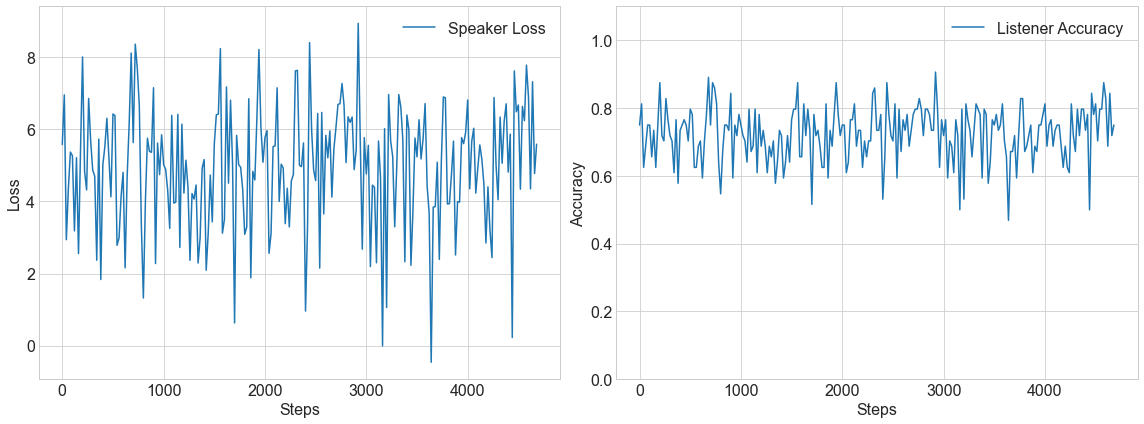

In [36]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 6))
columns = 2
rows = 1

fig.add_subplot(1,2, 1)
plt.plot(list(df_losses_coco_final_plot.index), df_losses_coco_final_plot['speaker_loss'], label=r"Speaker Loss")
# plt.plot(list(df_losses_coco_final_plot2.index), df_losses_coco_final_plot2['speaker_loss'], label=r"Similar Pairs")
# plt.plot(list(df_losses_coco_final_plot3.index), df_losses_coco_final_plot3['speaker_loss'], label=r"Fixed Listener, Random Pairs")

# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"]['losses'], label="Teacher-forcing loss")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"]['losses'], label="Auto-regressive loss")
# plt.ylim(ymax=6, ymin=0)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Loss", fontsize=16)

fig.add_subplot(1,2, 2)
plt.plot(list(df_losses_coco_final_plot.index), df_losses_coco_final_plot['accuracies'], label=r"Listener Accuracy")
# plt.plot(list(df_losses_coco_final_plot2.index), df_losses_coco_final_plot2['accuracies'], label=r"Similar Pairs")
# plt.plot(list(df_losses_coco_final_plot3.index), df_losses_coco_final_plot3['accuracies'], label=r"Fixed Listener, Random Pairs")

# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"]['losses'], label="Teacher-forcing loss")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"]['losses'], label="Auto-regressive loss")
plt.ylim(ymax=1.1, ymin=0)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
# plt.title("Speaker pretraining on MS COCO losses with exponentially decreasing teacher forcing rate")
# plt.show()
plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/3dshapes_fixedListener_similarFixed_exh_075_losses.png", dpi=500)

In [83]:
data_metrics = pd.read_csv("../../../../metrics_08-04.csv")

In [4]:
data_metrics.head()

,_id,name,run_id,steps,timestamps,values
0,"ObjectId(""62b84a45ae3df3d0d66b172b"")",train_losses,5,[0],"[""2022-06-26T12:00:05.244Z""]","[[0.5,0.5]]"
1,"ObjectId(""62b84a45ae3df3d0d66b172d"")",train_metrics,5,[0],"[""2022-06-26T12:00:05.244Z""]","[[1,2]]"
2,"ObjectId(""62b85a46ae3df3d0d66b1e62"")",train_losses,7,"[[0,1]]","[""2022-06-26T13:08:22.853Z""]","[[0.5,0.5]]"
3,"ObjectId(""62b85a46ae3df3d0d66b1e64"")",train_metrics,7,"[[0,1]]","[""2022-06-26T13:08:22.853Z""]","[[1,2]]"
4,"ObjectId(""62b85acfae3df3d0d66b1ec6"")",train_losses,8,"[[0,1]]","[""2022-06-26T13:10:39.759Z""]","[[0.5,0.5]]"


In [11]:
data_metrics["time"] = data_metrics["timestamps"].apply([lambda x: x[0]])

In [12]:
data_metrics.head()

,_id,name,run_id,steps,timestamps,values,time
0,"ObjectId(""62b84a45ae3df3d0d66b172b"")",train_losses,5,[0],"[""2022-06-26T12:00:05.244Z""]","[[0.5,0.5]]",[
1,"ObjectId(""62b84a45ae3df3d0d66b172d"")",train_metrics,5,[0],"[""2022-06-26T12:00:05.244Z""]","[[1,2]]",[
2,"ObjectId(""62b85a46ae3df3d0d66b1e62"")",train_losses,7,"[[0,1]]","[""2022-06-26T13:08:22.853Z""]","[[0.5,0.5]]",[
3,"ObjectId(""62b85a46ae3df3d0d66b1e64"")",train_metrics,7,"[[0,1]]","[""2022-06-26T13:08:22.853Z""]","[[1,2]]",[
4,"ObjectId(""62b85acfae3df3d0d66b1ec6"")",train_losses,8,"[[0,1]]","[""2022-06-26T13:10:39.759Z""]","[[0.5,0.5]]",[


In [38]:
# mask = data_metrics["timestamps"].isin(["2022-06-26"])
baseline_3dshapes = data_metrics[data_metrics['timestamps'].astype(str).str.contains("2022-07-27")]
# mask.head()
# baseline_3dshapes = data_metrics[mask]
# baseline_3dshapes = data_metrics[data_metrics["2022-07-27T15:50" in "timestamps"]]
baseline_3dshapes

,_id,name,run_id,steps,timestamps,values
684,"ObjectId(""62e08e4d3c497da8bf6e9585"")",speaker_loss_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[2.3255057334899902]
685,"ObjectId(""62e08e4d3c497da8bf6e9587"")",loss_structural_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[3.317340850830078]
686,"ObjectId(""62e08e4d3c497da8bf6e9589"")",loss_functional_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[-0.6500000953674316]
687,"ObjectId(""62e08e4d3c497da8bf6e958b"")",perplexities_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[27.586894989013672]
688,"ObjectId(""62e08e4d3c497da8bf6e958d"")",loss_listener_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[0.6976658701896667]
689,"ObjectId(""62e08e4d3c497da8bf6e958f"")",listener_acc_train,121,[0],"[""2022-07-27T01:00:59.754Z""]",[0.546875]
690,"ObjectId(""62e08e4d3c497da8bf6e9591"")",structural_drift_pred,121,"[0,1]","[""2022-07-27T01:00:59.754Z"",""2022-07-27T01:00:...","[-133.7180938720703,-131.44180297851562]"
691,"ObjectId(""62e08e4d3c497da8bf6e9593"")",structural_drift_true,121,"[0,1]","[""2022-07-27T01:00:59.754Z"",""2022-07-27T01:00:...","[-110.60255432128906,-110.60255432128906]"
692,"ObjectId(""62e08e4d3c497da8bf6e9595"")",semantic_drift_pred,121,"[0,1]","[""2022-07-27T01:00:59.754Z"",""2022-07-27T01:00:...","[-20.663074493408203,-20.605348587036133]"
693,"ObjectId(""62e08e4d3c497da8bf6e9597"")",semantic_drift_true,121,"[0,1]","[""2022-07-27T01:00:59.754Z"",""2022-07-27T01:00:...","[-20.558273315429688,-22.534849166870117]"


In [39]:
speaker_loss_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "speaker_loss_train")]["values"]

In [40]:
speaker_loss_baseline_3dshapes_list = [float(i) for i in speaker_loss_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]

In [41]:
listener_accuracy_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "listener_acc_train")]["values"]

In [42]:
listener_accuracy_baseline_3dshapes_list = [float(i) for i in listener_accuracy_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]

In [43]:
baseline_3dshapes_losses = pd.DataFrame({
    "speaker_loss": speaker_loss_baseline_3dshapes_list,
    "accuracies": listener_accuracy_baseline_3dshapes_list,
})
baseline_3dshapes_losses.to_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls075_49vocab_random_epoch_2_from_omni.csv")
# 

In [48]:
inds2keep_3dshapes_loss = list(np.arange(0, len(speaker_loss_baseline_3dshapes_list), 20))
inds2keep_3dshapes_loss_plot = [speaker_loss_baseline_3dshapes_list[i] for i in inds2keep_3dshapes_loss]

inds2keep_3dshapes_acc = list(np.arange(0, len(listener_accuracy_baseline_3dshapes_list), 20))
inds2keep_3dshapes_acc_plot = [listener_accuracy_baseline_3dshapes_list[i] for i in inds2keep_3dshapes_acc]
# df_losses_coco_final_plot.head()

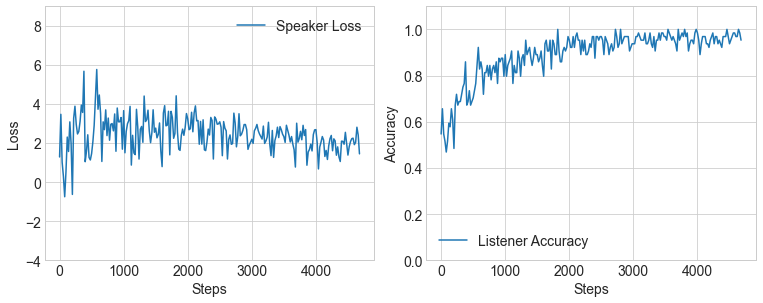

In [91]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 1

fig.add_subplot(2,3, 1)
plt.plot(inds2keep_3dshapes_loss, inds2keep_3dshapes_loss_plot, label="Speaker Loss")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"]['losses'], label="Teacher-forcing loss")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"]['losses'], label="Auto-regressive loss")
plt.ylim(ymax=9, ymin=-4)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)

fig.add_subplot(2,3, 2)
plt.plot(inds2keep_3dshapes_acc, inds2keep_3dshapes_acc_plot, label="Listener Accuracy")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "teacher_forcing"]['losses'], label="Teacher-forcing loss")
# plt.plot(list(df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"].index), df_losses_coco_final_plot[df_losses_coco_final_plot["train_type"] == "auto_regression"]['losses'], label="Auto-regressive loss")
plt.ylim(ymax=1.1, ymin=0)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# plt.title("Speaker pretraining on MS COCO losses with exponentially decreasing teacher forcing rate")
# plt.show()
plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/3dshapes_refgame_49_pure_075_random.png", dpi=500)

In [44]:
# plot all train results from coco in one plot
# concat all loss files 
df_losses_coco_final_0 = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls0_49vocab_random_epoch_2.csv")
df_losses_coco_final_025 = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls025_49vocab_random_epoch_2.csv")
df_losses_coco_final_05 = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls05_49vocab_random_epoch_2.csv")
df_losses_coco_final_075 = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls075_49vocab_random_epoch_2_from_omni.csv")
df_losses_coco_final_1 = pd.read_csv("../../../data/final/reference_games/3dshapes/losses_ref_game_3dshapes_pure_decoding_Ls1_49vocab_random_epoch_2.csv")

df_losses_coco_final_0["L_s"] = 0
df_losses_coco_final_025["L_s"] = 0.25
df_losses_coco_final_05["L_s"] = 0.5
df_losses_coco_final_075["L_s"] = 0.75
df_losses_coco_final_1["L_s"] = 1

In [45]:
inds2keep_coco_final_0 = list(np.arange(0, len(df_losses_coco_final_0), 80))
df_losses_coco_0_plot = df_losses_coco_final_0.reset_index()[df_losses_coco_final_0.reset_index().index.isin(inds2keep_coco_final_0)]
df_losses_coco_025_plot = df_losses_coco_final_025.reset_index()[df_losses_coco_final_025.reset_index().index.isin(inds2keep_coco_final_0)]
df_losses_coco_05_plot = df_losses_coco_final_05.reset_index()[df_losses_coco_final_05.reset_index().index.isin(inds2keep_coco_final_0)]
df_losses_coco_075_plot = df_losses_coco_final_075.reset_index()[df_losses_coco_final_075.reset_index().index.isin(inds2keep_coco_final_0)]
df_losses_coco_1_plot = df_losses_coco_final_1.reset_index()[df_losses_coco_final_1.reset_index().index.isin(inds2keep_coco_final_0)]


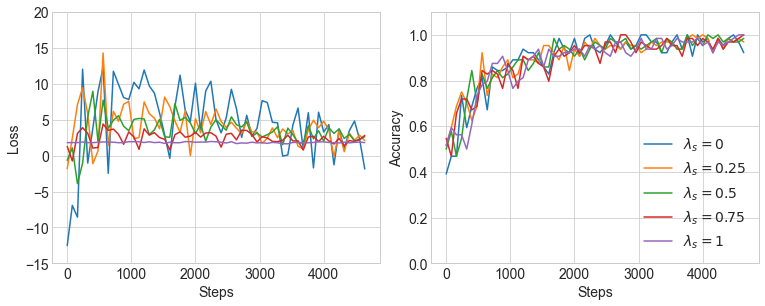

In [47]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 1

fig.add_subplot(2,3, 1)
plt.plot(list(df_losses_coco_0_plot.index), df_losses_coco_0_plot['speaker_loss'], label=r"$\lambda_s = 0$")
plt.plot(list(df_losses_coco_025_plot.index), df_losses_coco_025_plot['speaker_loss'], label=r"$\lambda_s = 0.25$")
plt.plot(list(df_losses_coco_05_plot.index), df_losses_coco_05_plot['speaker_loss'], label=r"$\lambda_s = 0.5$")
plt.plot(list(df_losses_coco_075_plot.index), df_losses_coco_075_plot['speaker_loss'], label=r"$\lambda_s = 0.75$")
plt.plot(list(df_losses_coco_1_plot.index), df_losses_coco_1_plot['speaker_loss'], label=r"$\lambda_s = 1$")

plt.ylim(ymax=20, ymin=-15)
# plt.legend(fontsize=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)

fig.add_subplot(2,3, 2)
plt.plot(list(df_losses_coco_0_plot.index), df_losses_coco_0_plot['accuracies'], label=r"$\lambda_s = 0$")
plt.plot(list(df_losses_coco_025_plot.index), df_losses_coco_025_plot['accuracies'], label=r"$\lambda_s = 0.25$")
plt.plot(list(df_losses_coco_05_plot.index), df_losses_coco_05_plot['accuracies'], label=r"$\lambda_s = 0.5$")
plt.plot(list(df_losses_coco_075_plot.index), df_losses_coco_075_plot['accuracies'], label=r"$\lambda_s = 0.75$")
plt.plot(list(df_losses_coco_1_plot.index), df_losses_coco_1_plot['accuracies'], label=r"$\lambda_s = 1$")

plt.ylim(ymax=1.1, ymin=0)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# plt.title("Speaker pretraining on MS COCO losses with exponentially decreasing teacher forcing rate")
# plt.show()
plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/shapes_refgame_49_pure_losses_all_Ls_random.png", dpi=500)

In [29]:
# summarize the three-validation steps drift metric dynamics
coco_baseline_metrics_0 = pd.read_csv("../../../data/final/reference_games/coco/metrics_ref_game_coco_pure_decoding_Ls0_4000vocab_random_epoch_2.csv")
coco_baseline_metrics_025 = pd.read_csv("../../../data/final/reference_games/coco/metrics_ref_game_coco_pure_decoding_Ls025_4000vocab_random_epoch_2.csv")
coco_baseline_metrics_05 = pd.read_csv("../../../data/final/reference_games/coco/metrics_ref_game_coco_pure_decoding_Ls05_4000vocab_random_epoch_2.csv")
coco_baseline_metrics_075 = pd.read_csv("../../../data/final/reference_games/coco/metrics_ref_game_coco_pure_decoding_Ls075_4000vocab_random_epoch_2.csv")
coco_baseline_metrics_1 = pd.read_csv("../../../data/final/reference_games/coco/metrics_ref_game_coco_pure_decoding_Ls1_4000vocab_random_epoch_2.csv")

In [6]:
coco_baseline_metrics.head()

NameError: name 'coco_baseline_metrics' is not defined

In [30]:
coco_baseline_metrics_0["semantic_drifts_true"] = coco_baseline_metrics_0["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_0["semantic_drifts_pred"] = coco_baseline_metrics_0["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_025["semantic_drifts_true"] = coco_baseline_metrics_025["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_025["semantic_drifts_pred"] = coco_baseline_metrics_025["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_05["semantic_drifts_true"] = coco_baseline_metrics_05["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_05["semantic_drifts_pred"] = coco_baseline_metrics_05["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_1["semantic_drifts_true"] = coco_baseline_metrics_1["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
coco_baseline_metrics_1["semantic_drifts_pred"] = coco_baseline_metrics_1["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

# coco_baseline_metrics.head()

In [31]:
# len(coco_baseline_metrics)/3
coco_baseline_metrics_075.head()

,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out,losses,ppl
0,1,-137.767517,-112.491592,-27.086138,-23.876503,0.765625,0.001503,0.570015,1,3.140412,23.113396
1,2,-129.442322,-110.132828,-20.449381,-3.782027,1.593750,0.001491,0.568389,1,3.150654,23.351322
2,3,-132.830917,-105.002960,-18.304955,-22.631281,1.281250,0.001792,0.580725,1,3.059583,21.318674
3,1,-136.880371,-112.491585,-18.461351,-13.774988,0.812500,0.005927,0.589125,1,3.191419,24.322908
4,2,-135.246063,-110.132828,-19.533123,-30.870106,0.906250,0.000840,0.571903,1,3.191634,24.328152


In [14]:
indices_metrics = [[i] * 3 for i in range(24)]
indices_metrics_flat = [i for j in indices_metrics for i in j ]
# coco_baseline_metrics_0['plot_steps'] = indices_metrics_flat
# coco_baseline_metrics_025['plot_steps'] = indices_metrics_flat
# coco_baseline_metrics_05['plot_steps'] = indices_metrics_flat
# coco_baseline_metrics_075['plot_steps'] = indices_metrics_flat
# coco_baseline_metrics_1['plot_steps'] = indices_metrics_flat
# # len(indices_metrics_flat)

In [60]:
coco_baseline_metrics.head()

,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out,losses,ppl,plot_steps
0,0,-139.729355,-109.381760,-77.6605,-68.9811,0.453125,-0.000711,0.570058,1,3.210995,24.803764,0
1,1,-138.443710,-112.491562,-76.5464,-70.9072,0.609375,-0.001622,0.578788,1,3.153470,23.417183,0
2,2,-137.612946,-110.132797,-79.7917,-68.6089,1.125000,-0.003334,0.555879,1,3.179435,24.033165,0
3,0,-136.230087,-109.381760,-77.5430,-69.3660,0.484375,0.001249,0.575227,1,3.200597,24.547182,1
4,1,-133.862823,-112.491554,-77.0772,-64.3318,0.828125,0.005113,0.568476,1,3.188069,24.241562,1


In [33]:
coco_baseline_metrics_0_summary = coco_baseline_metrics_0.groupby("plot_steps").mean().reset_index()
coco_baseline_metrics_025_summary = coco_baseline_metrics_025.groupby("plot_steps").mean().reset_index()
coco_baseline_metrics_05_summary = coco_baseline_metrics_05.groupby("plot_steps").mean().reset_index()
coco_baseline_metrics_075_summary = coco_baseline_metrics_075.groupby("plot_steps").mean().reset_index()
coco_baseline_metrics_1_summary = coco_baseline_metrics_1.groupby("plot_steps").mean().reset_index()

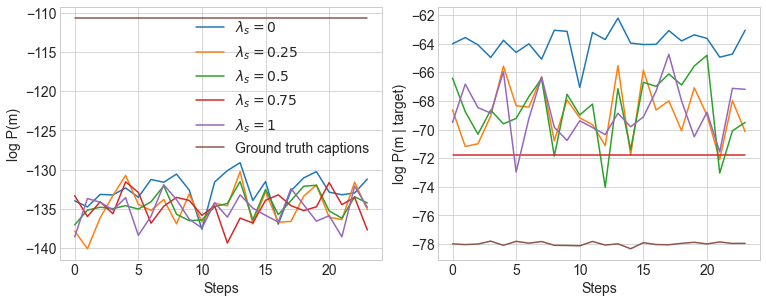

In [35]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 1

fig.add_subplot(2,3, 1)

plt.plot(coco_baseline_metrics_0_summary["plot_steps"], coco_baseline_metrics_0_summary["structural_drift_pred"], label=r"$\lambda_s = 0$")
plt.plot(coco_baseline_metrics_025_summary["plot_steps"], coco_baseline_metrics_025_summary["structural_drift_pred"], label=r"$\lambda_s = 0.25$")
plt.plot(coco_baseline_metrics_05_summary["plot_steps"], coco_baseline_metrics_05_summary["structural_drift_pred"], label=r"$\lambda_s = 0.5$")
plt.plot(coco_baseline_metrics_075_summary["plot_steps"], coco_baseline_metrics_075_summary["structural_drift_pred"], label=r"$\lambda_s = 0.75$")
plt.plot(coco_baseline_metrics_1_summary["plot_steps"], coco_baseline_metrics_1_summary["structural_drift_pred"], label=r"$\lambda_s = 1$")

plt.plot(coco_baseline_metrics_0_summary["plot_steps"], coco_baseline_metrics_0_summary["structural_drift_true"], label="Ground truth captions")
# plt.ylim(ymax=9, ymin=-4)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("log P(m)", fontsize=14)

fig.add_subplot(2,3, 2)
plt.plot(coco_baseline_metrics_0_summary["plot_steps"], coco_baseline_metrics_0_summary["semantic_drifts_pred"], label=r"$\lambda_s = 0$")
plt.plot(coco_baseline_metrics_025_summary["plot_steps"], coco_baseline_metrics_025_summary["semantic_drifts_pred"], label=r"$\lambda_s = 0.25$")
plt.plot(coco_baseline_metrics_05_summary["plot_steps"], coco_baseline_metrics_05_summary["semantic_drifts_pred"], label=r"$\lambda_s = 0.5$")
plt.plot(coco_baseline_metrics_075_summary["plot_steps"], [-71.8]*len(coco_baseline_metrics_075_summary["plot_steps"]), label=r"$\lambda_s = 0.75$") # coco_baseline_metrics_075_summary["semantic_drifts_pred"]
plt.plot(coco_baseline_metrics_1_summary["plot_steps"], coco_baseline_metrics_1_summary["semantic_drifts_pred"], label=r"$\lambda_s = 1$")

plt.plot(coco_baseline_metrics_0_summary["plot_steps"], coco_baseline_metrics_0_summary["semantic_drifts_true"], label="Ground truth captions")
# plt.ylim(ymax=9, ymin=-4)
# plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("log P(m | target)", fontsize=14)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/coco_structural_semantic_drift_4000_pure_L_s_all_random.png", dpi=500)

In [13]:
# try computing linear regressions on the metrics
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'

In [37]:
similar_3dshapes_metrics = pd.read_csv("../../../data/final/reference_games/3dshapes/metrics_ref_game_3dshapes_fixedListener_pure_decoding_Ls075_49vocab_similarFixed_epoch_2.csv")
similar_3dshapes_metrics['plot_steps'] = indices_metrics_flat
similar_3dshapes_metrics["semantic_drifts_true"] = similar_3dshapes_metrics["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
similar_3dshapes_metrics["semantic_drifts_pred"] = similar_3dshapes_metrics["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

similar_3dshapes_metrics_summary = similar_3dshapes_metrics.groupby("plot_steps").mean().reset_index()

# similar_3dshapes_metrics2 = pd.read_csv("../../../data/final/reference_games/coco/greedy/metrics_ref_game_coco_greedy_decoding_Ls075_4000vocab_random_epoch_2.csv")
# similar_3dshapes_metrics2['plot_steps'] = indices_metrics_flat
# similar_3dshapes_metrics2["semantic_drifts_true"] = similar_3dshapes_metrics2["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
# similar_3dshapes_metrics2["semantic_drifts_pred"] = similar_3dshapes_metrics2["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

# similar_3dshapes_metrics_summary2 = similar_3dshapes_metrics2.groupby("plot_steps").mean().reset_index()

# similar_3dshapes_metrics3 = pd.read_csv("../../../data/final/reference_games/coco/greedy/metrics_ref_game_coco_fixedListener_greedy_decoding_Ls075_4000vocab_random_epoch_2.csv")
# similar_3dshapes_metrics3['plot_steps'] = indices_metrics_flat
# similar_3dshapes_metrics3["semantic_drifts_true"] = similar_3dshapes_metrics3["semantic_drifts_true"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
# similar_3dshapes_metrics3["semantic_drifts_pred"] = similar_3dshapes_metrics3["semantic_drifts_pred"].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

# similar_3dshapes_metrics_summary3 = similar_3dshapes_metrics3.groupby("plot_steps").mean().reset_index()

In [25]:
similar_3dshapes_metrics_summary3.head() # for 3dshapes fixed listener, ground truth str drift for ls 0 : -164.66, for ls 075, -166.66
# --> shift the predicted drifts, to make them comparable

,plot_steps,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out,losses,ppl
0,0,1.0,-99.933441,-110.668704,-77.945733,-36.139500,1.078125,0.001965,0.576929,1.0,3.159092,23.565346
1,1,1.0,-94.508199,-110.668704,-78.096400,-36.885600,0.979167,0.000390,0.574655,1.0,3.190093,24.299286
2,2,1.0,-97.183474,-110.668706,-78.056100,-35.955967,0.838542,0.001325,0.583670,1.0,3.175658,23.944466
3,3,1.0,-104.352290,-110.668709,-77.774500,-37.012300,1.208333,0.000987,0.575752,1.0,3.164235,23.678348
4,4,1.0,-101.352188,-110.668711,-77.962100,-37.126633,0.765625,0.003384,0.569877,1.0,3.181667,24.105762


In [26]:
similar_3dshapes_metrics_summary2.head()

,plot_steps,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out,losses,ppl
0,0,1.0,-98.103251,-110.668706,-77.946233,-36.697233,1.052083,-0.001312,0.573358,1.0,3.169294,23.812462
1,1,1.0,-97.070129,-110.668706,-78.132500,-36.672600,0.916667,0.003261,0.572076,1.0,3.195425,24.428106
2,2,1.0,-98.318087,-110.668706,-78.178333,-37.162833,1.041667,-0.000946,0.571336,1.0,3.165060,23.702971
3,3,1.0,-101.293409,-110.668704,-78.171733,-38.196800,1.244792,0.003267,0.568685,1.0,3.221704,25.078945
4,4,1.0,-100.777682,-110.668706,-78.098933,-36.072467,0.921875,0.001197,0.569087,1.0,3.171899,23.862584


In [27]:
similar_3dshapes_metrics_summary.head()

,plot_steps,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out,losses,ppl
0,0,1.0,-99.845044,-111.972883,-78.293767,-37.498733,1.161458,0.002579,0.570694,1.0,3.220665,25.112897
1,1,1.0,-94.177902,-111.972883,-78.058400,-36.509833,0.916667,-0.001786,0.568903,1.0,3.230478,25.324940
2,2,1.0,-93.970650,-111.972883,-77.951567,-34.121067,0.911458,0.002551,0.574623,1.0,3.169481,23.869822
3,3,1.0,-102.858192,-111.972885,-78.374500,-37.299467,1.286458,0.001977,0.577736,1.0,3.213399,24.966540
4,4,1.0,-98.109591,-111.972888,-78.035633,-35.336900,0.937500,0.003643,0.580066,1.0,3.190314,24.331286


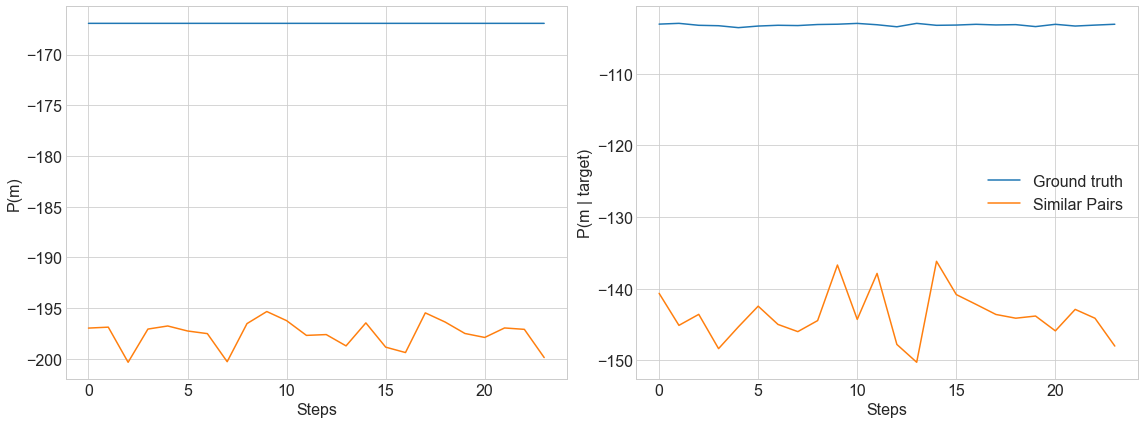

In [39]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 6))
columns = 2
rows = 1

fig.add_subplot(1,2, 1)

plt.plot(similar_3dshapes_metrics_summary["plot_steps"], similar_3dshapes_metrics_summary["structural_drift_true"], label=r"Ground Truth")
# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], [i  for i in similar_3dshapes_metrics_summary2["structural_drift_true"]], label=r"Mixed ground truth captions")
# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], similar_3dshapes_metrics_summary2["structural_drift_pred"], label=r"Baseline")
plt.plot(similar_3dshapes_metrics_summary["plot_steps"], similar_3dshapes_metrics_summary["structural_drift_pred"], label=r"Similar Pairs")
# plt.plot(similar_3dshapes_metrics_summary3["plot_steps"], similar_3dshapes_metrics_summary3["structural_drift_pred"], label=r"Fixed Listener, Random Pairs")

# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], [i  for i in similar_3dshapes_metrics_summary2["structural_drift_pred"]], label=r"Predicted mixed captions")


# plt.ylim(ymax=9, ymin=-4)
# plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("P(m)", fontsize=16)

fig.add_subplot(1,2, 2)
plt.plot(similar_3dshapes_metrics_summary["plot_steps"], similar_3dshapes_metrics_summary["semantic_drifts_true"], label=r"Ground truth")
# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], similar_3dshapes_metrics_summary2["semantic_drifts_true"], label=r"Mixed ground truth captions")
# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], similar_3dshapes_metrics_summary2["semantic_drifts_pred"], label=r"Baseline")
plt.plot(similar_3dshapes_metrics_summary["plot_steps"], similar_3dshapes_metrics_summary["semantic_drifts_pred"], label=r"Similar Pairs")
# plt.plot(similar_3dshapes_metrics_summary2["plot_steps"], similar_3dshapes_metrics_summary2["semantic_drifts_pred"], label=r"Predicted mixed captioPs")
# plt.plot(similar_3dshapes_metrics_summary3["plot_steps"], similar_3dshapes_metrics_summary3["semantic_drifts_pred"], label=r"Fixed Listener, Random Pairs")

# plt.ylim(ymax=9, ymin=-4)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("P(m | target)", fontsize=16)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/3dshapes_structural_semantic_drift_fixedListener_similarFixed_075.png", dpi=500)

In [31]:
str_pred_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "structural_drift_pred")]["values"]
str_pred_baseline_3dshapes_list = [float(i) for i in str_pred_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]
str_true_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "structural_drift_true")]["values"]
str_true_baseline_3dshapes_list = [float(i) for i in str_true_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]

sem_pred_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "semantic_drift_pred")]["values"]
sem_pred_baseline_3dshapes_list = [float(i) for i in sem_pred_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]
sem_true_baseline_3dshapes = baseline_3dshapes[(baseline_3dshapes["run_id"] == 128) & (baseline_3dshapes["name"] == "semantic_drift_true")]["values"]
sem_true_baseline_3dshapes_list = [float(i) for i in sem_true_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]

In [33]:
baseline_3dshapes_metrics = pd.DataFrame({
    "str_pred": str_pred_baseline_3dshapes_list,
    "str_true": str_true_baseline_3dshapes_list,
    "sem_pred": sem_pred_baseline_3dshapes_list,
    "sem_true": sem_true_baseline_3dshapes_list,
    "plot_steps": indices_metrics_flat,
})
baseline_3dshapes_metrics.to_csv("../../../data/final/reference_games/3dshapes/metrics_ref_game_3dshapes_pure_decoding_Ls075_49vocab_random_epoch_2_from_omni.csv")
# baseline_3dshapes_metrics_summary = baseline_3dshapes_metrics.groupby("plot_steps").mean().reset_index()


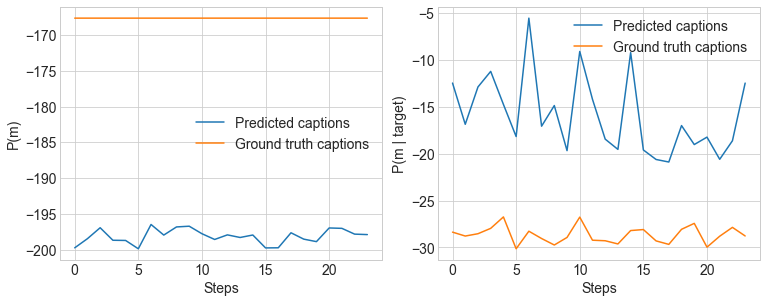

In [94]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 1

fig.add_subplot(2,3, 1)

plt.plot(baseline_3dshapes_metrics_summary["plot_steps"], baseline_3dshapes_metrics_summary["str_pred"], label="Predicted captions")
plt.plot(baseline_3dshapes_metrics_summary["plot_steps"], baseline_3dshapes_metrics_summary["str_true"], label="Ground truth captions")
# plt.ylim(ymax=9, ymin=-4)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("P(m)", fontsize=14)

fig.add_subplot(2,3, 2)
plt.plot(baseline_3dshapes_metrics_summary["plot_steps"], baseline_3dshapes_metrics_summary["sem_pred"], label="Predicted captions")
plt.plot(baseline_3dshapes_metrics_summary["plot_steps"], baseline_3dshapes_metrics_summary["sem_true"], label="Ground truth captions")
# plt.ylim(ymax=9, ymin=-4)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("P(m | target)", fontsize=14)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/3dshapes_structural_semantic_drift_49_pure_075_random.png", dpi=500)

The plots below are for the grid searches in order to put them into the Appendix.

In [181]:
# initial grid search with tf only speaker, over Ls and decoding strategy; plot listener accuracy and total speaker losses
# df_pure = pd.read_csv("../reference_game_coco_losses_tracked_iterLf_epoch_1.csv")
df_pure_0_s = data_metrics[(data_metrics["run_id"] == 49) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_0_l = data_metrics[(data_metrics["run_id"] == 49) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_0_s = data_metrics[(data_metrics["run_id"] == 50) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_0_l = data_metrics[(data_metrics["run_id"] == 50) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_05_s = data_metrics[(data_metrics["run_id"] == 52) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_05_l = data_metrics[(data_metrics["run_id"] == 52) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_05_s = data_metrics[(data_metrics["run_id"] == 53) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_05_l = data_metrics[(data_metrics["run_id"] == 53) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_075_s = data_metrics[(data_metrics["run_id"] == 55) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_075_l = data_metrics[(data_metrics["run_id"] == 55) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_075_s = data_metrics[(data_metrics["run_id"] == 56) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_075_l = data_metrics[(data_metrics["run_id"] == 56) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_exp_075_s = data_metrics[(data_metrics["run_id"] == 93) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_exp_075_l = data_metrics[(data_metrics["run_id"] == 93) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_exp_1_s = data_metrics[(data_metrics["run_id"] == 94) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_exp_1_l = data_metrics[(data_metrics["run_id"] == 94) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_1 = pd.read_csv("../functional_training_losses_wPretrained_noEnc_vocab4000_metrics_full_epoch_1.csv")

inds2keep_grid = list(np.arange(0, len(df_pure_0_s), 15))

In [132]:
# speaker_loss_baseline_3dshapes_list = [float(i) for i in speaker_loss_baseline_3dshapes.iloc[0].replace("[", "").replace("]", "").split(",") ]
len(df_exp_1_s)
df_pure_1.head()

,steps,speaker_s,speaker_f,listener,perplexities,accuracies,image_similarities
0,1,12.077395,0.564089,0.669893,175851.546875,0.531250,0.558477
1,2,12.578347,0.401202,0.885277,290206.250000,0.531250,0.566011
2,3,12.555408,-0.521670,0.810640,283625.062500,0.500000,0.565602
3,4,11.497829,-1.181250,0.925282,98501.734375,0.453125,0.579441
4,5,12.027944,-0.566570,0.700283,167366.890625,0.500000,0.547272


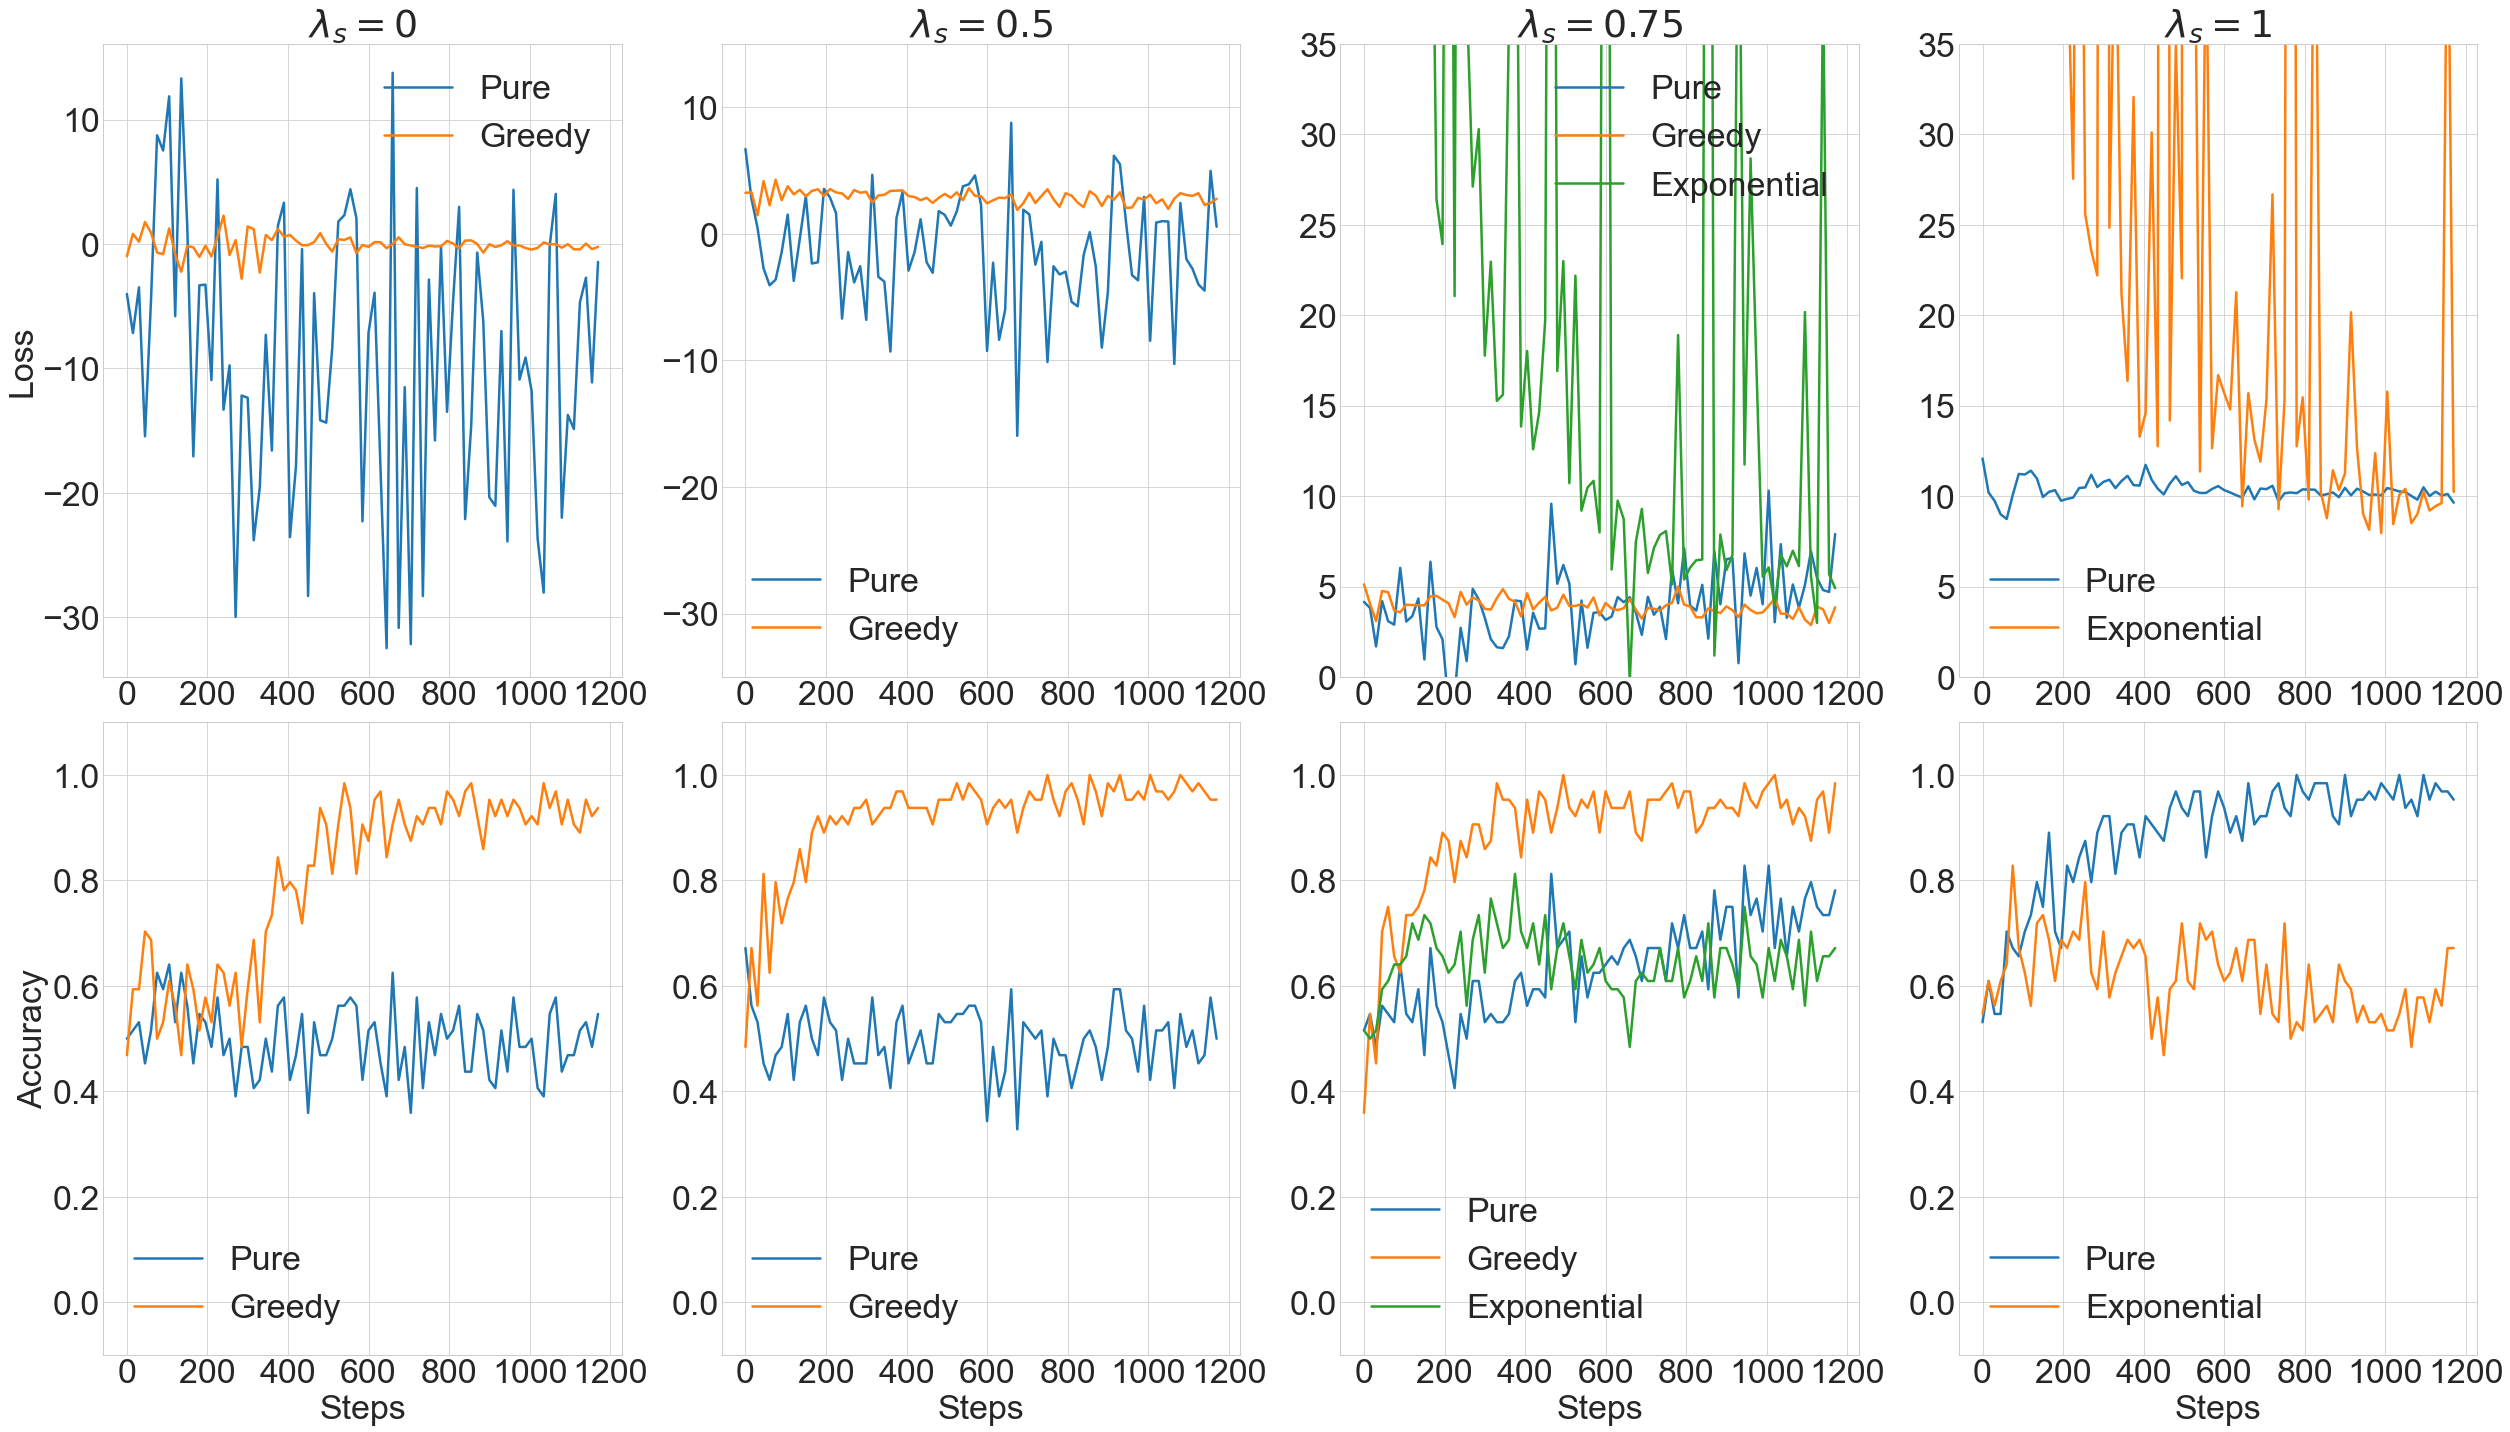

In [184]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(35, 20))
columns = 4
rows = 2

fig.add_subplot(2,4, 1)
plt.plot(inds2keep_grid, [float(df_pure_0_s[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_0_s[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.title(r"$\lambda_s=0$",fontsize=38)
# plt.ylim(ymax=6, ymin=1)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.ylabel("Loss", fontsize=34)

fig.add_subplot(2,4, 2)
plt.plot(inds2keep_grid, [float(df_pure_05_s[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_05_s[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.title(r"$\lambda_s=0.5$",fontsize=38)
plt.ylim(ymax=15, ymin=-35)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks([-30, -20, -10, 0, 10], fontsize=34)

fig.add_subplot(2,4, 3)
plt.plot(inds2keep_grid, [float(df_pure_075_s[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_075_s[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_exp_075_s[i]) for i in inds2keep_grid], label=r"Exponential", linewidth=2.5)
plt.title(r"$\lambda_s=0.75$",fontsize=38)
plt.ylim(ymax=35, ymin=0)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)

fig.add_subplot(2,4, 4)
plt.plot(inds2keep_grid, [float(df_pure_1["speaker_s"][i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_exp_1_s[i]) for i in inds2keep_grid], label=r"Exponential", linewidth=2.5)
plt.title(r"$\lambda_s=1$",fontsize=38)
plt.ylim(ymax=35, ymin=0)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)

##### second row #####
fig.add_subplot(2,4, 5)
plt.plot(inds2keep_grid, [float(df_pure_0_l[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_0_l[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.xlabel("Steps", fontsize=34)
plt.ylabel("Accuracy", fontsize=34)

fig.add_subplot(2,4, 6)
plt.plot(inds2keep_grid, [float(df_pure_05_l[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_05_l[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.xlabel("Steps", fontsize=34)

fig.add_subplot(2,4, 7)
plt.plot(inds2keep_grid, [float(df_pure_075_l[i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_greedy_075_l[i]) for i in inds2keep_grid], label=r"Greedy", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_exp_075_l[i]) for i in inds2keep_grid], label=r"Exponential", linewidth=2.5)
plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.xlabel("Steps", fontsize=34)

fig.add_subplot(2,4, 8)
plt.plot(inds2keep_grid, [float(df_pure_1["accuracies"][i]) for i in inds2keep_grid], label=r"Pure", linewidth=2.5)
plt.plot(inds2keep_grid, [float(df_exp_1_l[i]) for i in inds2keep_grid], label=r"Exponential", linewidth=2.5)
plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=34)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.xlabel("Steps", fontsize=34)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/grid_search_TF_only_Ls_decoding.png", dpi=500)

In [156]:
# second grid search: different pretraining + Ls + decoding

# initial grid search with tf only speaker, over Ls and decoding strategy; plot listener accuracy and total speaker losses
df_pure_0_tf_s = data_metrics[(data_metrics["run_id"] == 58) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_0_tf_l = data_metrics[(data_metrics["run_id"] == 58) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_0_topk_s = data_metrics[(data_metrics["run_id"] == 59) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_0_topk_l = data_metrics[(data_metrics["run_id"] == 59) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_0_tf_s = data_metrics[(data_metrics["run_id"] == 60) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_0_tf_l = data_metrics[(data_metrics["run_id"] == 60) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_0_topk_s = data_metrics[(data_metrics["run_id"] == 61) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_0_topk_l = data_metrics[(data_metrics["run_id"] == 61) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_075_tf_s = data_metrics[(data_metrics["run_id"] == 62) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_075_tf_l = data_metrics[(data_metrics["run_id"] == 62) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_pure_075_topk_s = data_metrics[(data_metrics["run_id"] == 63) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_pure_075_topk_l = data_metrics[(data_metrics["run_id"] == 63) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_075_tf_s = data_metrics[(data_metrics["run_id"] == 64) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_075_tf_l = data_metrics[(data_metrics["run_id"] == 64) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_greedy_075_topk_s = data_metrics[(data_metrics["run_id"] == 65) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_greedy_075_topk_l = data_metrics[(data_metrics["run_id"] == 65) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

inds2keep_grid = list(np.arange(0, len(df_pure_0_s), 15))

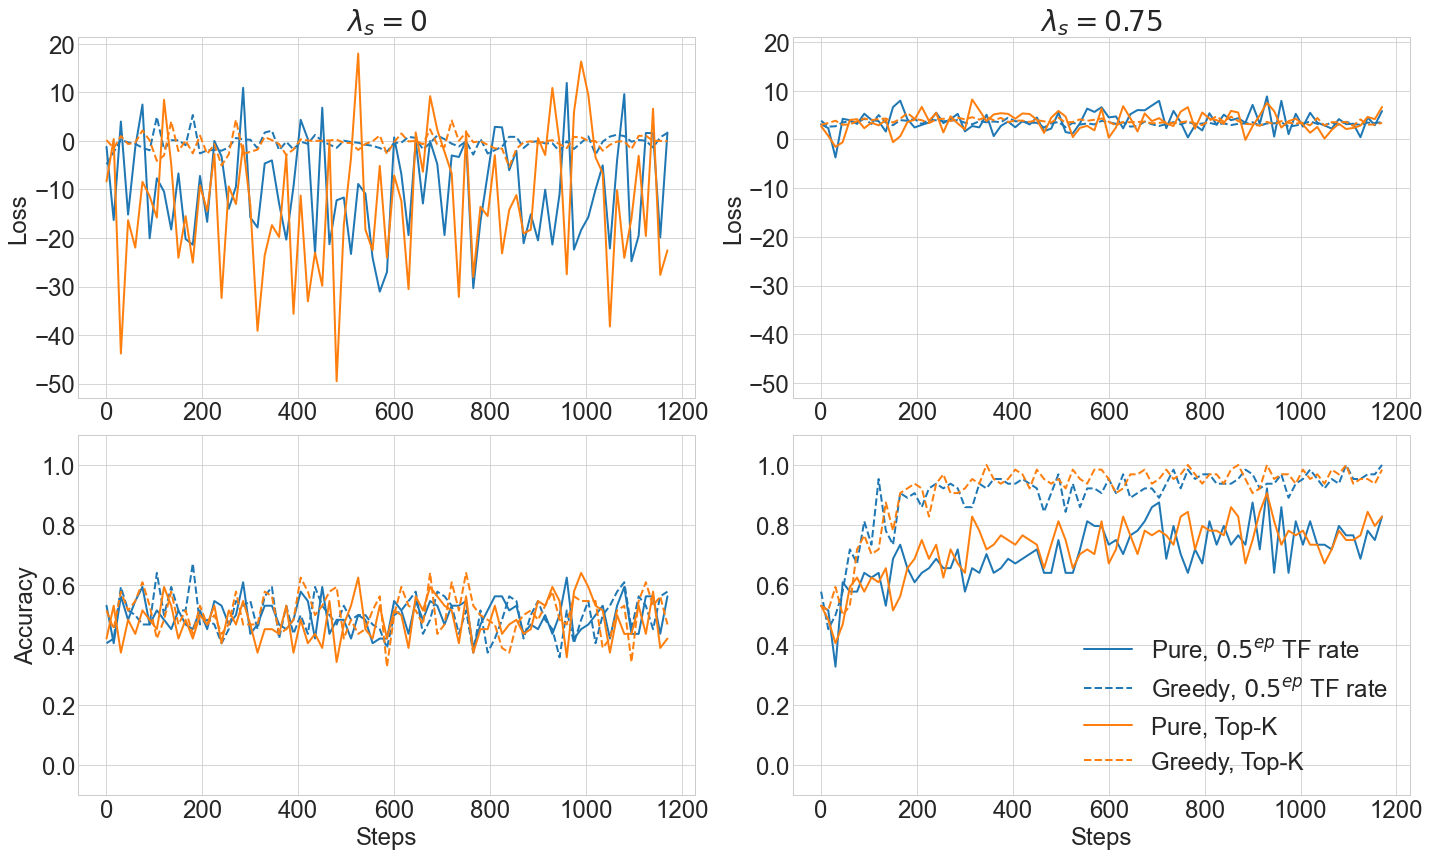

In [206]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(20, 12))
columns = 2
rows = 2

fig.add_subplot(2,2, 1)
plt.plot(inds2keep_grid, [float(df_pure_0_tf_s[i]) for i in inds2keep_grid], label=r"Pure, $0.5^{ep}$ TF rate", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_0_tf_s[i]) for i in inds2keep_grid], label=r"Greedy, $0.5^{ep}$ TF rate", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_0_topk_s[i]) for i in inds2keep_grid], label=r"Pure, Top-K", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_0_topk_s[i]) for i in inds2keep_grid], label=r"Greedy, Top-K", linewidth=2, color='#ff7f0e', linestyle="dashed")
plt.title(r"$\lambda_s=0$",fontsize=28)
# plt.ylim(ymax=6, ymin=1)
# plt.legend(fontsize=34)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("Loss", fontsize=24)

fig.add_subplot(2,2, 2)
plt.plot(inds2keep_grid, [float(df_pure_075_tf_s[i]) for i in inds2keep_grid], label=r"Pure, $0.5^{ep}$ TF rate", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_075_tf_s[i]) for i in inds2keep_grid], label=r"Greedy, $0.5^{ep}$ TF rate", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_075_topk_s[i]) for i in inds2keep_grid], label=r"Pure, Top-K", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_075_topk_s[i]) for i in inds2keep_grid], label=r"Greedy, Top-K", linewidth=2, color='#ff7f0e', linestyle="dashed")
plt.title(r"$\lambda_s=0.75$",fontsize=28)
plt.ylim(ymax=21, ymin=-53)
# plt.legend(fontsize=34)
plt.xticks(fontsize=24)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=24)
plt.ylabel("Loss", fontsize=24)
 ##### second row #####

fig.add_subplot(2,2, 3)
plt.plot(inds2keep_grid, [float(df_pure_0_tf_l[i]) for i in inds2keep_grid], label=r"Pure, $0.5^{ep}$ TF rate", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_0_tf_l[i]) for i in inds2keep_grid], label=r"Greedy, $0.5^{ep}$ TF rate", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_0_topk_l[i]) for i in inds2keep_grid], label=r"Pure, Top-K", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_0_topk_l[i]) for i in inds2keep_grid], label=r"Greedy, Top-K", linewidth=2, color='#ff7f0e', linestyle="dashed")
plt.ylim(ymax=1.1, ymin=-0.1)
# plt.legend(fontsize=34)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.xlabel("Steps", fontsize=24)

fig.add_subplot(2,2, 4)
plt.plot(inds2keep_grid, [float(df_pure_075_tf_l[i]) for i in inds2keep_grid], label=r"Pure, $0.5^{ep}$ TF rate", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_075_tf_l[i]) for i in inds2keep_grid], label=r"Greedy, $0.5^{ep}$ TF rate", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_075_topk_l[i]) for i in inds2keep_grid], label=r"Pure, Top-K", linewidth=2)
plt.plot(inds2keep_grid, [float(df_greedy_075_topk_l[i]) for i in inds2keep_grid], label=r"Greedy, Top-K", linewidth=2, color='#ff7f0e', linestyle="dashed")
plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Steps", fontsize=24)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/grid_search_pretraining_Ls_decoding.png", dpi=500)

In [185]:
# last grid search : 79 and 80, pretrain style Ls computation
df_tf_only_encode_s = data_metrics[(data_metrics["run_id"] == 79) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_tf_only_encode_l = data_metrics[(data_metrics["run_id"] == 79) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")

df_tf_encode_s = data_metrics[(data_metrics["run_id"] == 80) & (data_metrics["name"] == "speaker_loss_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")
df_tf_encode_l = data_metrics[(data_metrics["run_id"] == 80) & (data_metrics["name"] == "listener_acc_train")]["values"].iloc[0].replace("[", "").replace("]", "").split(",")


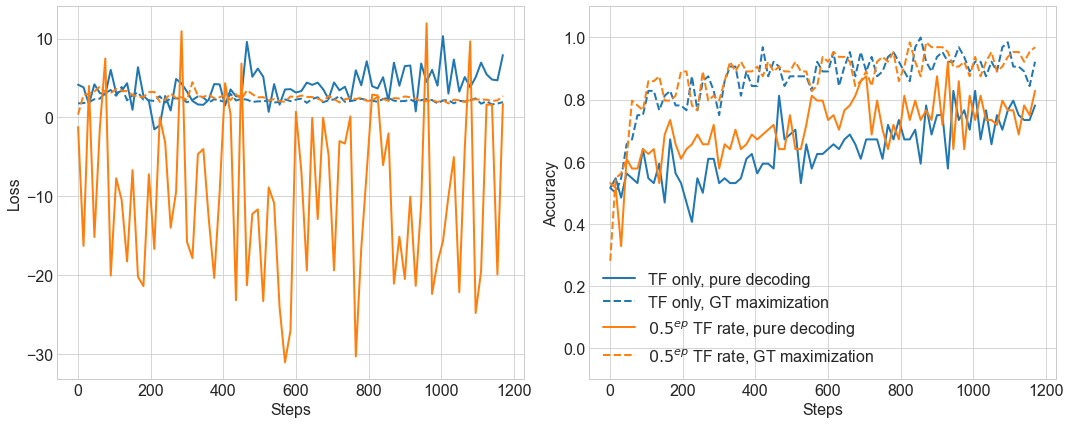

In [207]:
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(15, 6))
columns = 2
rows = 1

fig.add_subplot(1,2, 1)
plt.plot(inds2keep_grid, [float(df_pure_075_s[i]) for i in inds2keep_grid], label=r"TF only, pure decoding", linewidth=2)
plt.plot(inds2keep_grid, [float(df_tf_only_encode_s[i]) for i in inds2keep_grid], label=r"TF only", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_0_tf_s[i]) for i in inds2keep_grid], label=r"$0.5^{ep}$ TF rate, pure decoding", linewidth=2)
plt.plot(inds2keep_grid, [float(df_tf_encode_s[i]) for i in inds2keep_grid], label=r"$0.5^{ep}$ TF rate", linewidth=2,color='#ff7f0e', linestyle="dashed")

# plt.ylim(ymax=6, ymin=1)
# plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xlabel("Steps", fontsize=16)


fig.add_subplot(1,2, 2)
plt.plot(inds2keep_grid, [float(df_pure_075_l[i]) for i in inds2keep_grid], label=r"TF only, pure decoding", linewidth=2)
plt.plot(inds2keep_grid, [float(df_tf_only_encode_l[i]) for i in inds2keep_grid], label=r"TF only, GT maximization", linewidth=2, color='#1f77b4', linestyle="dashed")
plt.plot(inds2keep_grid, [float(df_pure_075_tf_l[i]) for i in inds2keep_grid], label=r"$0.5^{ep}$ TF rate, pure decoding", linewidth=2)
plt.plot(inds2keep_grid, [float(df_tf_encode_l[i]) for i in inds2keep_grid], label=r"$0.5^{ep}$ TF rate, GT maximization", linewidth=2,color='#ff7f0e', linestyle="dashed")

plt.ylim(ymax=1.1, ymin=-0.1)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Steps", fontsize=16)

plt.tight_layout()
# plt.savefig("../../../writing/thesis/images/grid_search_Ls_calculation.png", dpi=500)